<a href="https://colab.research.google.com/github/HodaMemar/Patient-Similarity-through-Representation/blob/main/CreateTree_Relabeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import networkx as nx
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Stage refers to the set of quadraples that are used to make the graph.
This collection is arranged according to the time dimension

In [ ]:

Stage_df1=pd.read_csv('...\\Stage.csv')

FileNotFoundError: ignored

We designed two types of stages to design two methods U-TTree and H_U_TTree. which is in H_U_TTree data extracted from past medical history.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
Stage_df2=pd.read_csv('/content/drive/MyDrive/PID2.csv',sep='')
Stage_df2
Times=Stage_df2.Time.unique()
TemporalEventTypes=Stage_df2.TemporalEventType.unique()
Retro=Stage_df2.loc[Stage_df2['TemporalEventType']=='Retro','Event'].unique()
print(Retro)
Stage_df2

['DiseaseDisorderMention']


,Time,TemporalEventType,Event,Value
0,1,Retro,DiseaseDisorderMention,Diabet Mellitus
1,1,New Finding,Demographic,Femail_40
2,2,New Finding,DiseaseDisorderMention,Diabet_Neu
3,3,RealTime,MainDrug,Insulin
4,3,RealTime,Glucose,High


<Figure size 640x480 with 0 Axes>

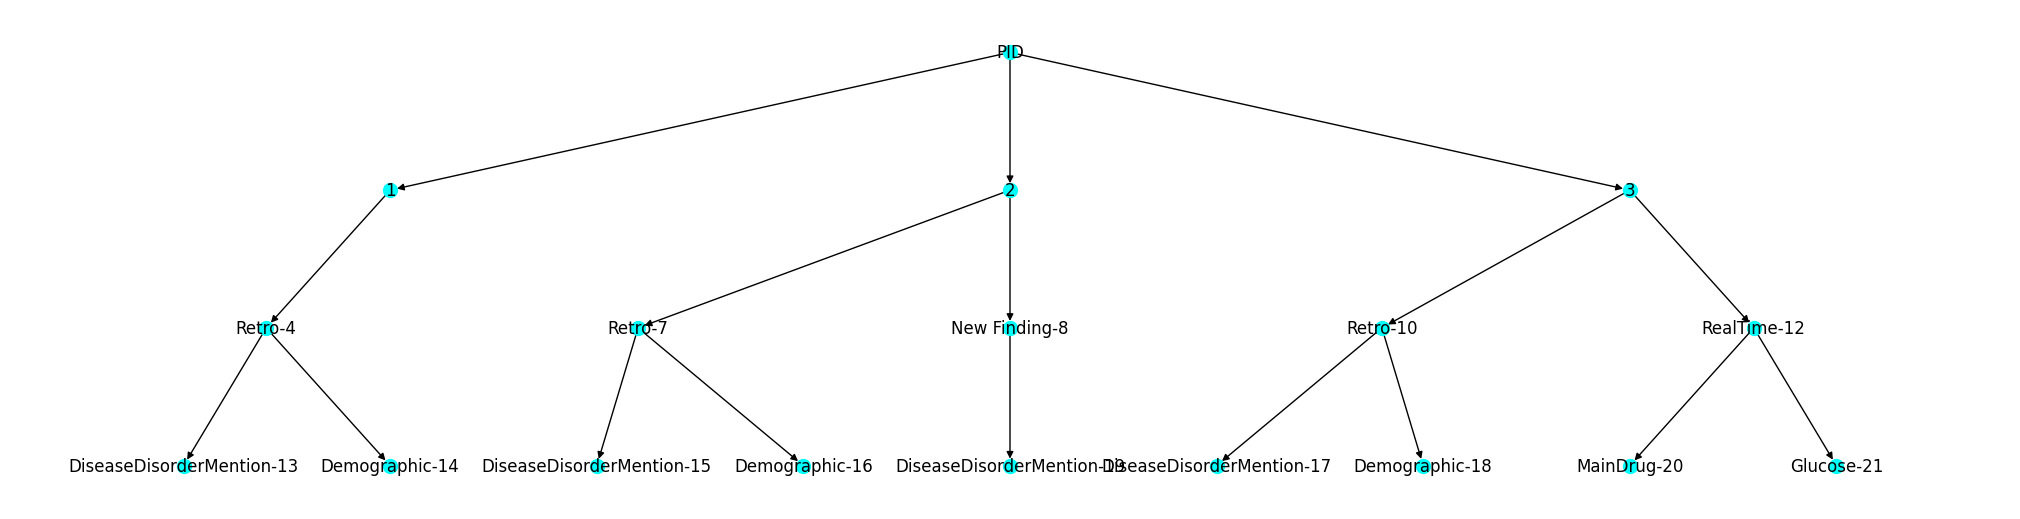

In [61]:
PG = nx.DiGraph()
PG.add_node('PID')
root='PID'
for i in Times:
  PG.add_node(i)
  PG.add_edge(root,i)


L_1=list(PG.successors(root))

for i in L_1:

  PG.add_node('Retro' + '-' +str(PG.number_of_nodes()), TE='Retro')
  PG.add_edge(i,'Retro'  + '-' +str(PG.number_of_nodes()-1))
  PG.add_node('New Finding'  + '-' +str(PG.number_of_nodes()), TE='New_Finding')
  PG.add_edge(i,'New Finding'  + '-' +str(PG.number_of_nodes()-1))
  PG.add_node('RealTime'  + '-' +str(PG.number_of_nodes()), TE='RealTime')
  PG.add_edge(i,'RealTime'  + '-' +str(PG.number_of_nodes()-1))



#-------------------------------------------------------------------------------------------------------
L2_Retro=[x for x,y in PG.nodes(data=True) if list(y.keys())==['TE'] and list(y.values())==['Retro']]

#or i in range(len(L2_Retro)):
#        PG.add_node('PastEvent_' + L2_Retro[i] )
#        PG.add_edge(L2_Retro[i] ,'PastEvent_' + L2_Retro[i] )

#L3_Retro=list(filter(lambda x:'PastEvent_' in str(x),PG.nodes))

for i in range(len(L2_Retro)):
        PG.add_node('DiseaseDisorderMention' + '-' +str(PG.number_of_nodes()) ,value='Diabet Mellitus')
        PG.add_edge(L2_Retro[i] ,'DiseaseDisorderMention' + '-' +str(PG.number_of_nodes()-1) )


        PG.add_node('Demographic' + '-' +str(PG.number_of_nodes()) ,value='Femail_40')
        PG.add_edge(L2_Retro[i] ,'Demographic' + '-' +str(PG.number_of_nodes()-1) )
#-------------------------------------------------------------------------------------------------------
L2_New_Finding=[x for x,y in PG.nodes(data=True) if list(y.keys())==['TE'] and list(y.values())==['New_Finding']]

for i in range(len(L2_New_Finding)):
  predecessor=list(PG.predecessors(L2_New_Finding[i]))
  Tmp_df_New_Finding=Stage_df2.loc[(Stage_df2['TemporalEventType']=='New Finding') &
                       (Stage_df2['Event']!='Demographic') & (Stage_df2['Time']==predecessor[0]), ['Event', 'Value']]
  Ls_Event_New_Finding=Tmp_df_New_Finding.reset_index()[['Event', 'Value']].values.tolist()
  if len(Ls_Event_New_Finding)>0:
    for j in range(len(Ls_Event_New_Finding)):
      PG.add_node(Ls_Event_New_Finding[j][0]+ '-' +str(PG.number_of_nodes()),value=Ls_Event_New_Finding[j][1])
      PG.add_edge(L2_New_Finding[i],Ls_Event_New_Finding[j][0]+ '-' +str(PG.number_of_nodes()-1))

#---------------------------------------------------------------------------------------------------------

L2_RealTime=[x for x,y in PG.nodes(data=True) if list(y.keys())==['TE'] and list(y.values())==['RealTime']]

for i in range(len(L2_RealTime)):
  predecessor=list(PG.predecessors(L2_RealTime[i]))
  Tmp_df_RealTime=Stage_df2.loc[(Stage_df2['TemporalEventType']=='RealTime') &
                                   (Stage_df2['Time']==predecessor[0]), ['Event', 'Value']]
  Ls_Event_RealTime=Tmp_df_RealTime.reset_index()[['Event', 'Value']].values.tolist()
  if len(Ls_Event_RealTime)>0:
    for j in range(len(Ls_Event_RealTime)):
      PG.add_node(Ls_Event_RealTime[j][0]+ '-' +str(PG.number_of_nodes()),value=Ls_Event_RealTime[j][1])
      PG.add_edge(L2_RealTime[i],Ls_Event_RealTime[j][0]+ '-' +str(PG.number_of_nodes()-1))

#---------------------------------------------------------------------------------------------------------
remove_nodes=[]
for node in PG.nodes:
   if (nx.shortest_path_length(PG, source='PID', target=node)==2 and PG.out_degree(node)==0):
     remove_nodes.append(node)
for i in remove_nodes:
  PG.remove_node(i)
#---------------------------------------------------------------------------------------------------------
pos = hierarchy_pos(PG,'PID')

plt.figure(1)
plt.figure(2,figsize=(20,5))
nx.draw(PG, pos=pos,with_labels=True,node_size = 100,node_color = 'cyan')
plt.show()

In [5]:
def hierarchy_pos(G, root, levels=None, width=1., height=1.):
    '''If there is a cycle that is reachable from root, then this will see infinite recursion.
       G: the graph
       root: the root node
       levels: a dictionary
               key: level number (starting from 0)
               value: number of nodes in this level
       width: horizontal space allocated for drawing
       height: vertical space allocated for drawing'''
    TOTAL = "total"
    CURRENT = "current"
    def make_levels(levels, node=root, currentLevel=0, parent=None):
        """Compute the number of nodes for each level
        """
        if not currentLevel in levels:
            levels[currentLevel] = {TOTAL : 0, CURRENT : 0}
        levels[currentLevel][TOTAL] += 1
        neighbors = G.neighbors(node)
        for neighbor in neighbors:
            if not neighbor == parent:
                levels =  make_levels(levels, neighbor, currentLevel + 1, node)
        return levels

    def make_pos(pos, node=root, currentLevel=0, parent=None, vert_loc=0):
        dx = 1/levels[currentLevel][TOTAL]
        left = dx/2
        pos[node] = ((left + dx*levels[currentLevel][CURRENT])*width, vert_loc)
        levels[currentLevel][CURRENT] += 1
        neighbors = G.neighbors(node)
        for neighbor in neighbors:
            if not neighbor == parent:
                pos = make_pos(pos, neighbor, currentLevel + 1, node, vert_loc-vert_gap)
        return pos
    if levels is None:
        levels = make_levels({})
    else:
        levels = {l:{TOTAL: levels[l], CURRENT:0} for l in levels}
    vert_gap = height / (max([l for l in levels])+1)
    return make_pos({})

In [ ]:
EElist_Subject_id=Stage_df1['Subject_id'].unique().tolist()
list_Events=['procedure','Drug','past medical history']
foot_print=[]
Subgraph_id_num=3
list_sen=[]
counter=1
print(len(list_Subject_id))
G_Global = nx.Graph()
for row_1 in list_Subject_id:
    root=''
    G = nx.Graph()
    foot_print=[]
    foot_print.append('DiseaseDisorderMention')
    foot_print.append('procedure')
    foot_print.append('Drug')
    label="Patient_"
    foot_print.append(label+str(row_1))
    G.add_node(label+str(row_1))
    root=label+str(row_1)
    for row_2 in range(Subgraph_id_num):
            label="SG_"

            G.add_node(label+str(row_2))
            foot_print.append(label+str(row_2))
            G.add_edge("Patient_"+str(row_1), label+str(row_2))
            if row_2==1:
                list_Timestame=Stage_df1.loc[Stage_df1['Subject_id']==row_1]['Timestame_id'].unique().tolist()
                list_Timestame.sort()
                for index, row_3 in enumerate(list_Timestame):
                    label="T_"

                    current=label+str(index)

                    G.add_node(current)
                    foot_print.append(current)

                    if index==0:
                            previous="SG_"+str(row_2)


                    elif index>0:
                            previous = label+str(index-1)

                    G.add_edge(previous, current)
                    foot_print.append(previous)

                    list_Events=[]
                    list_Events=list(Stage_df1.loc[(Stage_df1['Subject_id']==row_1) & (Stage_df1['Subgraph_id']==row_2) & (Stage_df1['Timestame_id']==row_3)]['Event type'].unique())

                    #print(list_Events)
                    for row_4 in list_Events:
                            label="T"+str(index) + "_E "

                            foot_print.append("T"+str(index) + "_E")

                            inx=list(Stage_df1.index[(Stage_df1['Subject_id']==row_1) & (Stage_df1['Subgraph_id']==row_2) & (Stage_df1['Timestame_id']==row_3)& (Stage_df1['Event type']==row_4)])

                            entity=label +str(row_4)+' '+str(Stage_df1.iloc[inx[0]]['entity'])
                            value=''
                            for index, row_5 in enumerate(inx):
                                value=value+' '+str(Stage_df1.iloc[row_5]['value'])
                            value=label +str(row_4)+' '+value

                            G.add_node(entity+' '+value)
                            G.add_edge(current, entity+' '+value)

    #graph_plit(G)
    list_sen.append([row_1,traverse_tree(G,root,foot_print)])
    print(counter,row_1)
    counter=counter+1
    G_Global=G
G_Global

1
1 123


In [ ]:
sen=pd.DataFrame(list_sen,columns=['Subject_id','String'])
sen.loc[0].String

' proc1 1 proc2 2 d1 1 2 d3 3 past medical history m1 past medical history 1 past medical history m2 past medical history 2 past medical history m3 past medical history 3 past medical history m4 past medical history 4'

In [ ]:
sorted(G_Global)




['Patient_123',
 'SG_0',
 'SG_1',
 'SG_2',
 'T0_E procedure proc1 T0_E procedure  1',
 'T1_E procedure proc2 T1_E procedure  2',
 'T2_E Drug d1 T2_E Drug  1 2',
 'T3_E Drug d3 T3_E Drug  3',
 'T4_E past medical history m1 T4_E past medical history  1',
 'T5_E past medical history m2 T5_E past medical history  2',
 'T6_E past medical history m3 T6_E past medical history  3',
 'T7_E past medical history m4 T7_E past medical history  4',
 'T_0',
 'T_1',
 'T_2',
 'T_3',
 'T_4',
 'T_5',
 'T_6',
 'T_7',
 'T_8']

<Figure size 640x480 with 0 Axes>

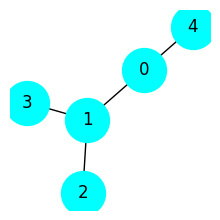

{1: 0, 4: 0, 2: 1, 3: 1}


<Figure size 640x480 with 0 Axes>

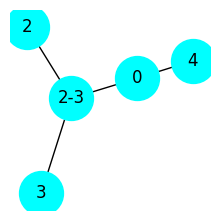

{'2-3': 0, 4: 0, 2: '2-3', 3: '2-3'}
2-3-4


<Figure size 640x480 with 0 Axes>

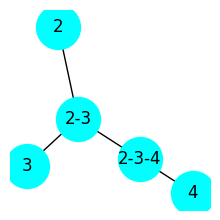

DiGraph with 5 nodes and 4 edges


In [ ]:
G=nx.Graph()
G.add_node(1)
G.add_node(2)
G.add_node(3)
G.add_node(0)
G.add_edge(1,2)
G.add_edge(1,3)
G.add_edge(0,1)
G.add_edge(0,4)

root=0
pos = nx.spring_layout(G, seed=3113794652)  # positions for all nodes




plt.figure(1)
plt.figure(2,figsize=(2,2))

nx.draw(G,with_labels=True,node_size = 1000,node_color = 'cyan')
plt.show()

D=dict(nx.bfs_predecessors(G, 0))
print(D)

L_D_1=[str(k) for k,v in D.items() if str(v) == '1']
new_label_1='-'.join(L_D_1)

mapping = {1:new_label_1}
G = nx.relabel_nodes(G, mapping)

plt.figure(1)
plt.figure(2,figsize=(2,2))
nx.draw(G,with_labels=True,node_size = 1000,node_color = 'cyan')
plt.show()

D=dict(nx.bfs_predecessors(G, 0))
print(D)

L_D_0=[str(k) for k,v in D.items() if str(v) == '0']
new_label_0='-'.join(L_D_0)
print(new_label_0)
mapping = {0:new_label_0}
root=new_label_0
G = nx.relabel_nodes(G, mapping)

plt.figure(1)
plt.figure(2,figsize=(2,2))
nx.draw(G,with_labels=True,node_size = 1000,node_color = 'cyan')
plt.show()
T = nx.bfs_tree(G, source=root)
print(T)

In [ ]:
bfs_string=list(T.nodes())
bfs_string

['2-3-4', '2-3', 4, 2, 3]

In [ ]:
mapping = {0: "a", 1: "b", 2: "c"}
H = nx.relabel_nodes(G, mapping)
sorted(H)

['a', 'b', 'c']

In [ ]:
def traverse_tree(G,source,foot_print):
    T = nx.bfs_tree(G, source=root)
    bfs_string=list(T.nodes())

    new=[]
    stopwords = foot_print
    tokenized_sents = [word_tokenize(i) for i in bfs_string]
    for i in tokenized_sents:
        words=i
        for word in list(words):  # iterating on a copy since removing will mess things up
            if word in stopwords:
                words.remove(word)
        if(len(words)>0):
            new.append(words)
    sen=''
    for i in range(len(new)):
        sen=sen +' '+(' '.join(map(str, new[i])))
    return(sen)

In this cell we can plot a generated graph.

In [ ]:
def graph_plit(G):

    G.nodes
    plt.figure(1)
    plt.figure(2,figsize=(2,2))

    list_root=[label+str(row_1)]
    list_subgraph=['SG_1','SG_2','SG_0']
    list_Time=['T_1','T_2']
    pos=nx.spring_layout(G)

    nx.draw(G, pos=pos, node_size = 1200, with_labels=True,node_color = 'silver')
    nx.draw_networkx_nodes(G, pos=pos,nodelist = list_root, node_color = 'red', node_size = 1500)
    nx.draw_networkx_nodes(G, pos=pos,nodelist = list_subgraph, node_color = 'orange', node_size = 1400)
    nx.draw_networkx_nodes(G, pos=pos,nodelist = list_Time, node_color = 'gold', node_size = 1300)
    nx.draw(G,with_labels=True,node_size = 1500,node_color = 'cyan')
    nx.draw_networkx_nodes(G, nodelist = ['Patient_1'], node_color = 'red', node_size = 200)
    plt.show()

When method breadth first search is used to traverse the generated tree, the following alternative way can be used to generate compounds.
What is important is to maintain the order of clinical events in each time window.

In [ ]:
ls_doc_patient=[]
for i in range(len(ls_patient)):
    try:
    #for each patients
        print(ls_patient[i])
        df_tmp=Stage_Total.loc[Stage_Total['admission_Id']==ls_patient[i]]
        ls_time=df_tmp.Timestame_id.unique().tolist()
        ls_time.sort()
        UnD=Stage_df_Note.loc[(Stage_df_Note['ID']==ls_patient[i]),['ICD'] ].values[0]


        doc_S_Non_TT=''
        doc_U_Non_TT=''
        doc_S_TT=''
        doc_S_U_TT=''
        doc_S_U_TT_R=''
        for j in range(len(ls_time)):
            # in each time windows
            df_tmp_ent=df_tmp.loc[df_tmp['Timestame_id']==ls_time[j]]
            df_tmp_ent=df_tmp_ent.sort_values('entity')

            tmp_S_Non_TT=''
            tmp_U_Non_TT=''
            tmp_S_TT=''
            tmp_S_U_TT=''
            tmp_S_U_TT_R=''

            for k in range(len(df_tmp_ent)):
                tmp_S_Non_TT=tmp_S_Non_TT+ ' ' + re.sub(r"\W+|_-", "", df_tmp_ent.iloc[k].entity)
            doc_S_Non_TT=doc_S_Non_TT+ tmp_S_Non_TT
    #---------------------------------------------------------
            for k in range(len(df_tmp_ent)):
                tmp_S_TT=tmp_S_TT + re.sub(r"\W+|_-", "", df_tmp_ent.iloc[k].entity) + \
                                               re.sub(r"\W+|_-", "", df_tmp_ent.iloc[k].value)
            doc_S_TT=doc_S_TT+ ' ' +tmp_S_TT
    #---------------------------------------------------------

            tmp_S_U_TT_R=tmp_S_U_TT_R+' '+tmp_S_TT+' '+ re.sub(r"\W+|_-", " ", str(UnD))
            doc_S_U_TT_R=doc_S_U_TT_R+ ' ' +tmp_S_U_TT_R

        doc_S_U_TT=doc_S_TT + ' ' + UnD
        doc_U_Non_TT=df_U_pref.loc[df_U['ID']==ls_patient[i]].Doc
        ls_doc_patient.append([ls_patient[i],doc_S_Non_TT,doc_U_Non_TT,doc_S_TT,doc_S_U_TT,doc_S_U_TT_R])

    except:
        print('error')




st=pd.DataFrame(ls_doc_patient,columns=['ID','doc_S_Non_TT','doc_U_Non_TT','doc_S_TT','doc_S_U_TT','doc_S_U_TT_R'])
st